# Machine Translation Using Transformer with Additive Attention: English to Thai

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.2.0+cu121'

In [4]:
torchtext.__version__

'0.16.2+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
from datasets import load_dataset

# Dataset from Hugging Face
dataset = load_dataset('kvush/english_thai_texts')

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 59859
    })
})


In [7]:
sample_input_text = dataset['train']['input_text'][:5]
print(sample_input_text)

['Service, scallops, all - top notch in every way!', 'Seth set the iron down on the table but it flipped over because the table was not durable.', 'Excellent food, wine and service!', "The best place in Vegas for gyros. I've had gyros in just about every place in town. Hands down this is the best.", 'Kevin was worried Kenneth would win the cross country race, because Kevin was currently behind.']


In [8]:
sample_translated_text = dataset['train']['translated_text'][:5]
print(sample_translated_text)

['บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!', 'เสธวางเหล็กลงบนโต๊ะ แต่มันพลิกคว่ำเพราะโต๊ะไม่ทนทาน', 'ยอดเยี่ยมกับอาหาร ไวน์ และบริการ!', 'สถานที่ที่ดีที่สุดในเวกัสสำหรับไจโร ฉันได้ลองไจโรในเกือบทุกสถานที่ในเมืองนี้ และไม่มีข้อโต้แย้งใดๆ เลยว่านี่คือสิ่งที่ดีที่สุด', 'เควินกังวลว่าเคนเน็ธจะชนะการแข่งขันครอสคันทรี เพราะเควินตามหลังอยู่']


In [9]:
SRC_LANGUAGE = 'input_text'
TRG_LANGUAGE = 'translated_text'

In [10]:
from datasets import DatasetDict

train_test_split = dataset['train'].train_test_split(test_size=0.3, seed=42)  # 70% train and 30% test/val

# Split the 30% portion into 50% test and 50% validation
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

# New DatasetDict
dataset = DatasetDict({
    'train': train_test_split['train'],
    'val': val_test_split['train'],
    'test': val_test_split['test']
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 41901
    })
    val: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 8979
    })
    test: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 8979
    })
})


In [11]:
train = [(row[SRC_LANGUAGE], row[TRG_LANGUAGE]) for row in dataset['train']]
val = [(row[SRC_LANGUAGE], row[TRG_LANGUAGE]) for row in dataset['val']]
test = [(row[SRC_LANGUAGE], row[TRG_LANGUAGE]) for row in dataset['test']]

In [12]:
train[0]

('After Angela got a perm, her hair was in poor condition. After Kayla offered to fix it, Kayla felt very helpful.',
 'หลังจากแองเจล่าได้ผมหยิกแล้ว ผมของเธออยู่ในสภาพย่ำแย่ หลังจากเคลล่าเสนอว่าจะซ่อมมัน เคลล่ารู้สึกช่วยเหลือดีมาก')

In [13]:
val[0]

("Ben needed to change the baby's diaper and bottle. However, the baby started to cry because it was hungry so he got the bottle .",
 'เบนจำเป็นต้องเปลี่ยนผ้าอ้อมและขวดนมของลูกน้อย อย่างไรก็ตาม ลูกน้อยเริ่มร้องไห้เพราะหิวโหย ดังนั้นเขาจึงหยิบขวดนมขึ้นมา')

In [14]:
test[0]

('Disappointing Service!\\n\\nFood was just Ok.\\n\\nThe Wolfe needs to take his name off this one.',
 'บริการน่าผิดหวัง! อาหารก็แค่พอใช้ วอลฟ์ควรเอาชื่อของเขาออกจากเรื่องนี้')

## 2. EDA - simple investigation

In [15]:
# Example of train
sample = next(iter(train))
sample

('After Angela got a perm, her hair was in poor condition. After Kayla offered to fix it, Kayla felt very helpful.',
 'หลังจากแองเจล่าได้ผมหยิกแล้ว ผมของเธออยู่ในสภาพย่ำแย่ หลังจากเคลล่าเสนอว่าจะซ่อมมัน เคลล่ารู้สึกช่วยเหลือดีมาก')

In [16]:
train_size = len(list(iter(train)))
train_size

41901

In [17]:
val_size = len(list(iter(val)))
val_size

8979

In [18]:
test_size = len(list(iter(test)))
test_size

8979

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [19]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [20]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import word_tokenize

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = word_tokenize

In [21]:
# Example of tokenization of the English part
print("English Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

English Sentence:  After Angela got a perm, her hair was in poor condition. After Kayla offered to fix it, Kayla felt very helpful.
Tokenization:  ['After', 'Angela', 'got', 'a', 'perm', ',', 'her', 'hair', 'was', 'in', 'poor', 'condition', '.', 'After', 'Kayla', 'offered', 'to', 'fix', 'it', ',', 'Kayla', 'felt', 'very', 'helpful', '.']


In [22]:
# Example of tokenization of the Thai part
print("Thai Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Thai Sentence:  หลังจากแองเจล่าได้ผมหยิกแล้ว ผมของเธออยู่ในสภาพย่ำแย่ หลังจากเคลล่าเสนอว่าจะซ่อมมัน เคลล่ารู้สึกช่วยเหลือดีมาก
Tokenization:  ['หลังจาก', 'แอ', 'ง', 'เจ', 'ล่า', 'ได้', 'ผมหยิก', 'แล้ว', ' ', 'ผม', 'ของ', 'เธอ', 'อยู่', 'ใน', 'สภาพ', 'ย่ำแย่', ' ', 'หลังจาก', 'เค', 'ล', 'ล่า', 'เสนอ', 'ว่า', 'จะ', 'ซ่อม', 'มัน', ' ', 'เค', 'ล', 'ล่า', 'รู้สึก', 'ช่วยเหลือ', 'ดีมาก']


A function to tokenize our input.

In [23]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [24]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [25]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [26]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[46, 12, 10, 0, 10]

In [27]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1234]

'medication'

In [28]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [29]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [30]:
#check unique vocabularies
len(mapping)

16628

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [32]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [33]:
for en, _, th in train_loader:
    break

In [34]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 48])
Thai shape:  torch.Size([64, 66])


## 5. Design the model

### Encoder Layer

In [35]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [36]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [37]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        # Linear transformations for Q, K, V
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        # Output linear transformation
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        # Dropout layer
        self.dropout  = nn.Dropout(dropout)
        
        # Scaling factor
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        # Added weights for Additive Attention
        self.W1 = nn.Linear(self.head_dim, self.head_dim)
        self.W2 = nn.Linear(self.head_dim, self.head_dim)
        self.v = nn.Linear(self.head_dim, 1)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        # Linear projections
        Q = self.fc_q(query)  # [batch_size, query_len, hid_dim]
        K = self.fc_k(key)    # [batch_size, key_len, hid_dim]
        V = self.fc_v(value)  # [batch_size, value_len, hid_dim]
        
        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        query_len = query.shape[1]
        key_len   = key.shape[1]

        # Additive Attention (using W1, W2, and v)
        query_transformed = self.W1(Q).view(batch_size, self.n_heads, query_len, 1, self.head_dim)  # [batch_size, n_heads, query_len, 1, head_dim]
        key_transformed   = self.W2(K).view(batch_size, self.n_heads, 1, key_len, self.head_dim)    # [batch_size, n_heads, 1, key_len, head_dim]
        
        energy = torch.tanh(query_transformed + key_transformed)  # [batch_size, n_heads, query_len, key_len]
        energy = self.v(energy).squeeze(-1)  # [batch_size, n_heads, query_len, key_len]

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # Compute attention weights
        attention = torch.softmax(energy, dim=-1)
        
        # Ensure the dimensions align for matmul (attention @ V)
        x = torch.matmul(self.dropout(attention), V)  # [batch_size, n_heads, query_len, head_dim]
        
        # Reshape the result back to the original sequence length
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        
        # Final output projection
        x = self.fc_o(x)
        
        return x, attention

### Position-wise Feedforward Layer

In [38]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [39]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [41]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [42]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [43]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16628, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (W1): Linear(in_features=32, out_features=32, bias=True)
          (W2): Linear(in_features=32, out_features=32, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=True)
        )
        (feedforward): PositionwiseFeedforwardLayer(
    

In [44]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4256768
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2982400
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [45]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [46]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [47]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [48]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}-additive.pt'

train_losses = []
valid_losses = []
total_time = 0

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    total_time += (end_time - start_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 2s
	Train Loss: 4.922 | Train PPL: 137.319
	 Val. Loss: 3.977 |  Val. PPL:  53.336
Epoch: 02 | Time: 1m 1s
	Train Loss: 3.713 | Train PPL:  40.977
	 Val. Loss: 3.457 |  Val. PPL:  31.722
Epoch: 03 | Time: 1m 2s
	Train Loss: 3.014 | Train PPL:  20.359
	 Val. Loss: 2.772 |  Val. PPL:  15.995
Epoch: 04 | Time: 1m 2s
	Train Loss: 2.375 | Train PPL:  10.751
	 Val. Loss: 2.405 |  Val. PPL:  11.074
Epoch: 05 | Time: 1m 2s
	Train Loss: 1.967 | Train PPL:   7.152
	 Val. Loss: 2.213 |  Val. PPL:   9.145
Epoch: 06 | Time: 1m 2s
	Train Loss: 1.688 | Train PPL:   5.409
	 Val. Loss: 2.154 |  Val. PPL:   8.617
Epoch: 07 | Time: 1m 1s
	Train Loss: 1.482 | Train PPL:   4.403
	 Val. Loss: 2.113 |  Val. PPL:   8.269
Epoch: 08 | Time: 1m 2s
	Train Loss: 1.321 | Train PPL:   3.748
	 Val. Loss: 2.060 |  Val. PPL:   7.843
Epoch: 09 | Time: 1m 2s
	Train Loss: 1.195 | Train PPL:   3.304
	 Val. Loss: 2.046 |  Val. PPL:   7.735
Epoch: 10 | Time: 1m 2s
	Train Loss: 1.094 | Train PPL:   2.985


In [51]:
avg_epoch_time = total_time / num_epochs
avg_epoch_mins = avg_epoch_time // 60
avg_epoch_secs = avg_epoch_time % 60

print(f'Average Epoch Time: {int(avg_epoch_mins)}m {int(avg_epoch_secs)}s')

Average Epoch Time: 1m 2s


Text(0, 0.5, 'loss')

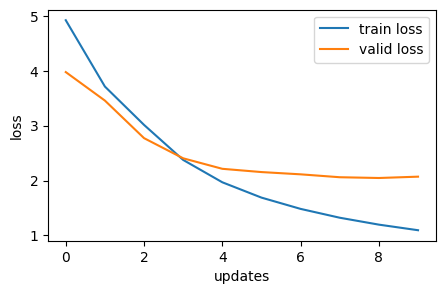

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [53]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.047 | Test PPL:   7.743 |


## 7. Test on some random news

In [54]:
sample[0]

'After Angela got a perm, her hair was in poor condition. After Kayla offered to fix it, Kayla felt very helpful.'

In [55]:
sample[1]

'หลังจากแองเจล่าได้ผมหยิกแล้ว ผมของเธออยู่ในสภาพย่ำแย่ หลังจากเคลล่าเสนอว่าจะซ่อมมัน เคลล่ารู้สึกช่วยเหลือดีมาก'

In [56]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([    2,   437,   212,    94,    10, 11725,     6,    60,   237,     8,
           18,   481,  1460,     4,   437,   195,   662,     7,  1017,    21,
            6,   195,   385,    39,   391,     4,     3], device='cuda:0')

In [57]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,  161,  378,  394,   70,  183,   18, 3676,   43,    4,  248,    9,
          46,   35,   11, 1203, 3420,    4,  161,  108,   93,  183,  667,   33,
          22,  799,   25,    4,  108,   93,  183,  117,  433,  128,    3],
       device='cuda:0')

In [58]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [59]:
trg_text = trg_text.reshape(1, -1)

In [60]:
src_text.shape, trg_text.shape

(torch.Size([1, 27]), torch.Size([1, 35]))

In [61]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [62]:
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [63]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 35, 11650])

Since batch size is 1, we just take off that dimension

In [64]:
output = output.squeeze(0)

In [65]:
output.shape

torch.Size([35, 11650])

We shall remove the first token since it's zeroes anyway

In [66]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([34, 11650])

Then we just take the top token with highest probabilities

In [67]:
output_max = output.argmax(1) #returns max indices

In [68]:
output_max

tensor([ 378,  394,   70,  183,   18, 3676,   43,    4,  248,    9,   46,   35,
          11, 1203, 3420,    4,  161,  108,   93,  183,  667,   74,   65,  799,
          25,   32,  108,   93,  183,  117,  433,  128,    3,    3],
       device='cuda:0')

Get the mapping of the target language

In [69]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [70]:
for token in output_max:
    print(mapping[token.item()])

แอ
ง
เจ
ล่า
ได้
ผมหยิก
แล้ว
 
ผม
ของ
เธอ
อยู่
ใน
สภาพ
ย่ำแย่
 
หลังจาก
เค
ล
ล่า
เสนอ
ที่จะ
ต้อง
ซ่อม
มัน
ให้
เค
ล
ล่า
รู้สึก
ช่วยเหลือ
ดีมาก
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [71]:
attentions.shape

torch.Size([1, 8, 35, 27])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [72]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([35, 27])

In [73]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'After',
 'Angela',
 'got',
 'a',
 'perm',
 ',',
 'her',
 'hair',
 'was',
 'in',
 'poor',
 'condition',
 '.',
 'After',
 'Kayla',
 'offered',
 'to',
 'fix',
 'it',
 ',',
 'Kayla',
 'felt',
 'very',
 'helpful',
 '.',
 '<eos>']

In [74]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'แอ',
 'ง',
 'เจ',
 'ล่า',
 'ได้',
 'ผมหยิก',
 'แล้ว',
 ' ',
 'ผม',
 'ของ',
 'เธอ',
 'อยู่',
 'ใน',
 'สภาพ',
 'ย่ำแย่',
 ' ',
 'หลังจาก',
 'เค',
 'ล',
 'ล่า',
 'เสนอ',
 'ที่จะ',
 'ต้อง',
 'ซ่อม',
 'มัน',
 'ให้',
 'เค',
 'ล',
 'ล่า',
 'รู้สึก',
 'ช่วยเหลือ',
 'ดีมาก',
 '<eos>',
 '<eos>']

In [75]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_1825366/59549304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_1825366/59549304.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

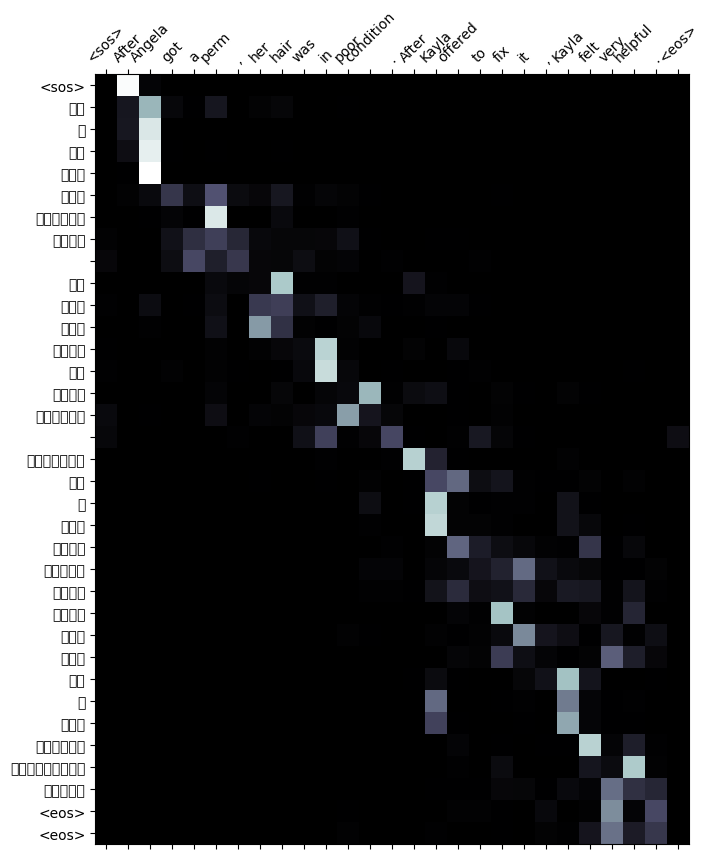

In [76]:
display_attention(src_tokens, trg_tokens, attention)